# Autoencoder - on the MNIST dataset:

The following is an illustration/exercise in using an Auto-Encoder on image data. The general idea is, that if one can encode (i.e. represent with "few" parameters) images, and then from this encoding decode them again to obtain "almost" the same images, then the few parameters (in a latent space) contains the basic information about the images.

![](AutoEncoder.png "")

An AutoEncoder is trained by requiring that the output images match the input images *best possible*, which is (of course) represented by a loss function. Thus, **an AutoEncoder does not require labels**, and is as such unsupervised learning. The power lies in that one gets a good representation of the data through the latent space (the size of which you can choose) for essentially any NN-based method, here a CNN.

This can then be used (aggresively!) for many things such as:
* Compression (with loss!) of the images (to the size of the latent space)
* De-noising images
* Anomaly detection
* Unsupervised learning (e.g. clustering) on images, sound, graphs, etc.

In the example at hand, we consider the MNIST dataset (28x28 (=784) images of digits), and autoencode these images into a latent space of size 4. We then project this latent space onto just two dimensions using UMAP, and see if we (or a clustering algorithm) can detect clusters and possibly determine how many digits there are... *without ever having known anything about arabic numerals!!!*

***

Authors: Amalie Mygind and Troels Petersen (based on example from Medium)<br>
Date: 14th of May 2023 (latest version)

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import random 

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from umap import UMAP

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import itertools

c:\Users\Simon Andersen\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# simon's generalized version of the above autoencoder:

class Encoder(nn.Module):
    def __init__(
        self,
        encoded_space_dim: int,
        input_channels: int = 1,
        input_size: tuple[int, int] = (28, 28),
        conv_channels: list[int] = [8, 16, 32],
        kernel_sizes: list[int] = [3, 3, 3],
        strides: list[int] = [2, 2, 2],
        paddings: list[int] = [1, 1, 0],
        linear_dims: list[int] = [128],
        use_batchnorm: bool = True,
        activation: nn.Module = nn.ReLU(True),
    ):
        super().__init__()

        assert len(conv_channels) == len(kernel_sizes) == len(strides) == len(paddings)

        # --- Convolutional layers ---
        layers = []
        in_ch = input_channels
        for out_ch, k, s, p in zip(conv_channels, kernel_sizes, strides, paddings):
            layers.append(nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_ch))
            layers.append(activation)
            in_ch = out_ch

        self.encoder_cnn = nn.Sequential(*layers)

        # --- Infer flatten shape automatically using dummy forward pass ---
        with torch.no_grad():
            dummy = torch.zeros(1, input_channels, *input_size)
            conv_out = self.encoder_cnn(dummy)
            self._conv_output_shape = conv_out.shape[1:]  # (C, H, W)
            self._flattened_dim = int(torch.tensor(self._conv_output_shape).prod())

        # --- Linear layers ---
        fc_layers = []
        prev_dim = self._flattened_dim
        for dim in linear_dims:
            fc_layers.append(nn.Linear(prev_dim, dim))
            fc_layers.append(activation)
            prev_dim = dim
        fc_layers.append(nn.Linear(prev_dim, encoded_space_dim))
        self.encoder_lin = nn.Sequential(*fc_layers)

        self.flatten = nn.Flatten(start_dim=1)

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):
    def __init__(
        self,
        encoded_space_dim: int,
        conv_output_shape: tuple[int, int, int],
        output_channels: int = 1,
        conv_channels: list[int] = [32, 16, 8],
        kernel_sizes: list[int] = [3, 3, 3],
        strides: list[int] = [2, 2, 2],
        paddings: list[int] = [0, 1, 1],
        output_paddings: list[int] = [0, 1, 1],
        linear_dims: list[int] = [128],
        use_batchnorm: bool = True,
        activation: nn.Module = nn.ReLU(True),
    ):
        super().__init__()

        # --- Linear section ---
        fc_layers = []
        prev_dim = encoded_space_dim
        for dim in linear_dims:
            fc_layers.append(nn.Linear(prev_dim, dim))
            fc_layers.append(activation)
            prev_dim = dim
        fc_layers.append(nn.Linear(prev_dim, int(torch.tensor(conv_output_shape).prod())))
        fc_layers.append(activation)
        self.decoder_lin = nn.Sequential(*fc_layers)

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=conv_output_shape)

        # --- Transposed convs ---
        layers = []
        in_chs = conv_channels
        out_chs = conv_channels[1:] + [output_channels]
        for in_ch, out_ch, k, s, p, op in zip(in_chs, out_chs, kernel_sizes, strides, paddings, output_paddings):
            layers.append(nn.ConvTranspose2d(in_ch, out_ch, k, stride=s, padding=p, output_padding=op))
            if out_ch != output_channels:
                if use_batchnorm:
                    layers.append(nn.BatchNorm2d(out_ch))
                layers.append(activation)

        self.decoder_conv = nn.Sequential(*layers)

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x


##### Define training and validation functions:

### Training function
def train_epoch(encoder, decoder, dataloader, loss_fn, optimizer, device):
    encoder.train()
    decoder.train()
    train_loss = []

    for image_batch, _ in dataloader:
        # Move batch to device
        image_batch = image_batch.to(device)

        # Forward pass
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)

        # Compute loss
        loss = loss_fn(decoded_data, image_batch)

        # Backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

### Testing function
def test_epoch(encoder, decoder, dataloader, loss_fn, device):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        conc_out = []
        conc_label = []

        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)

            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)

            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())

        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)

        val_loss = loss_fn(conc_out, conc_label)

    return val_loss.item()

### Plot reconstruction outputs
def plot_ae_outputs(encoder, decoder, test_dataset, device, n=10):
    plt.figure(figsize=(16, 4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i: np.where(targets == i)[0][0] for i in range(n)}

    encoder.eval()
    decoder.eval()

    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)

        with torch.no_grad():
            rec_img = decoder(encoder(img))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Original images')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Reconstructed images')

    plt.show()

# Function to plot confusion matrix:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          savefig = ''):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=16)
        plt.yticks(tick_marks, target_names, fontsize=16)
        

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=13,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=16,
                     color="white" if cm[i, j] > thresh else "black")


    #plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel(f'Predicted label\n\n accuracy={accuracy:0.3f}; misclass={misclass:0.3f}', fontsize=16)
    cbar.ax.set_ylabel('Number of items',  labelpad=20, rotation=270, fontsize=16)   
    
    
    if savefig: plt.savefig(savefig, bbox_inches='tight')
    
    plt.show()

In [4]:
# Convert data to torch.FloatTensor
transform = transforms.ToTensor()

# Load the training and test datasets
train_dataset = datasets.MNIST('dataset', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST('dataset', train=False, download=True, transform=transform)

In [5]:
# Split training data into training and validation data:
full_len = len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(full_len-full_len*0.2), int(full_len*0.2)])
batch_size=256

In [6]:
len(train_data), len(val_data), len(test_dataset)

(48000, 12000, 10000)

### Question - do we need to split the data?

We somehow always split the data into these three datasets, but given that we are doing unsupervised learning here, try to think about the degree to which we need to divide the data in this way.

In [7]:
# Create PyTorch dataloaders for data:
train_loader = DataLoader(train_data, batch_size=batch_size)
valid_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

In [13]:
input_size = (28, 28)

linear_dims = [256]
encoded_space_dim = 6

# Set learning parameters
lr = 0.001
weight_decay = 1e-05

encoder_kwargs = {
    "encoded_space_dim": encoded_space_dim,
    "input_channels": 1,
    "conv_channels": [8, 16, 32],
    "kernel_sizes": [3, 3, 3],
    "strides": [2, 2, 2],
    "paddings": [1, 1, 0],
    "linear_dims": linear_dims,
    "use_batchnorm": True,
    "activation": nn.ReLU(True),
    }
decoder_kwargs = {
    "encoded_space_dim": encoded_space_dim,
    "output_channels": encoder_kwargs["input_channels"],
    "conv_channels": encoder_kwargs["conv_channels"][::-1],
    "kernel_sizes": encoder_kwargs["kernel_sizes"][::-1],
    "strides": encoder_kwargs["strides"][::-1],
    "paddings": encoder_kwargs["paddings"][::-1],
    "output_paddings": encoder_kwargs["paddings"][::-1],
    "linear_dims": encoder_kwargs["linear_dims"][::-1],
    "use_batchnorm": encoder_kwargs["use_batchnorm"],
    "activation": nn.ReLU(True),
    }

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

encoder = Encoder(input_size=input_size, **encoder_kwargs)
decoder = Decoder(conv_output_shape=encoder._conv_output_shape, **decoder_kwargs)

encoder.to(device)
decoder.to(device)

num_params_enc = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
num_params_dec = sum(p.numel() for p in decoder.parameters() if p.requires_grad)
print('Number of parameters in encoder: %d' % num_params_enc)
print('Number of parameters in decoder: %d' % num_params_dec)

# Define loss function and training parameters:

# Define the loss function
loss_fn = nn.MSELoss()

# Set the random seed for reproducible results
torch.manual_seed(42)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=weight_decay)

Using device: cuda
NVIDIA GeForce 940MX
Memory Usage:
Allocated: 0.0 GB
Cached:    0.1 GB
Number of parameters in encoder: 81526
Number of parameters in decoder: 81713


### Question - what is the dimension of the latent space?

Ask yourself, how many dimensions we boild the images down to, i.e. how many numbers represent what the images look like?

NOTE: You may want to launch the training cell below (which takes a few minutes) and then think about the answer.

In [16]:
do_training = False
if do_training:
    # Train the model
    num_epochs = 50
    diz_loss = {'train_loss':[],'val_loss':[]}
    for epoch in range(num_epochs):
        train_loss = train_epoch(encoder,decoder, train_loader, loss_fn, optim, device)
        val_loss = test_epoch(encoder,decoder,test_loader,loss_fn, device)
        print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
        diz_loss['train_loss'].append(train_loss)
        diz_loss['val_loss'].append(val_loss)
        if epoch % 10 == 0:
            plot_ae_outputs(encoder,decoder,test_dataset=test_dataset, device=device, n=10) 

    # save the trained model
    torch.save({
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'loss': diz_loss,
    }, "autoencoder.pt")
else:
    ## load the trained model
    checkpoint = torch.load("autoencoder.pt", map_location=device)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    optim.load_state_dict(checkpoint['optimizer_state_dict'])
    diz_loss = checkpoint['loss']
    print('Model loaded from checkpoint.')

Model loaded from checkpoint.


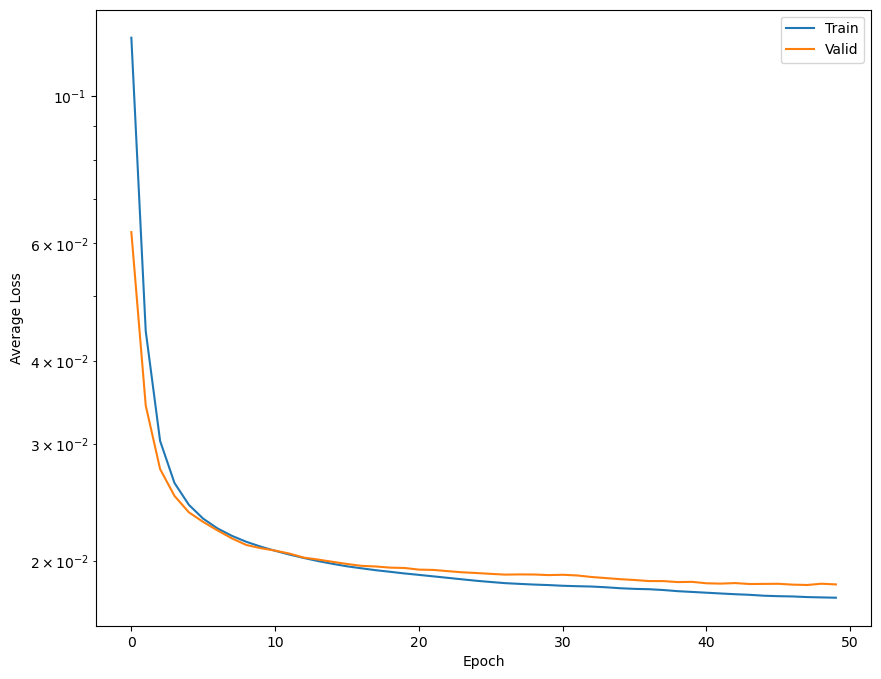

In [15]:
# Plot losses over epochs:
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

### Extract latent space representation

In [17]:
# Perform forward pass on test set and subtract latent layer (and labels):
latent_test = []
labels_test = []
for step, (images, labels) in enumerate(test_loader): 
    with torch.no_grad():
        images = images.to(device)
        latent = encoder(images)
    latent_test.extend(latent.cpu().numpy())
    labels_test.extend(labels.cpu().numpy())  
    
# labels_str = list(map(str, labels_test))
    
    
print(f'latent shape: {np.shape(latent_test)}, labels shape: {np.shape(labels_test)}')

latent shape: (10000, 6), labels shape: (10000,)


## Reduce latent space with UMAP

In [18]:
# Fit a (possibly parametric!) UMAP embedding to the latent space representation:
# embedder = ParametricUMAP(n_epochs=50, n_neighbors=20, min_dist=0.1)
embedder = UMAP(n_neighbors=50, min_dist=0.2)
embedding = embedder.fit_transform(latent_test)

### Question - can you "train" UMAP on a training set, and then apply the same model to a test set?

Seeing how t-SNE and UMAP iteratively got to their resulting projections, do you think that at the end of the process there is a model, that can be applied to other data? And if not, can you think about, how one could construct a good approximation?

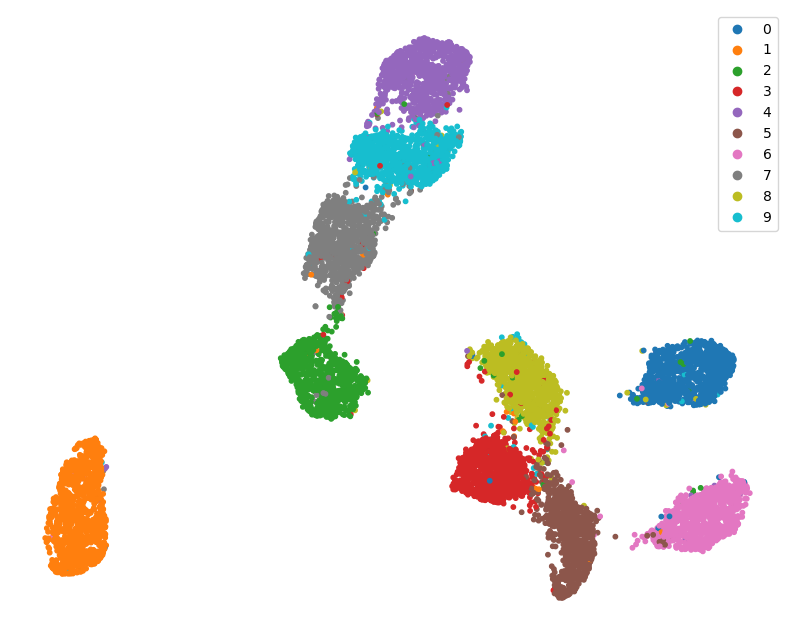

In [19]:
# Plot embedding without example images:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = plt.cm.tab10
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=labels_test, s=10, cmap=cmap)
ax.legend(*scatter.legend_elements())
ax.axis("off");

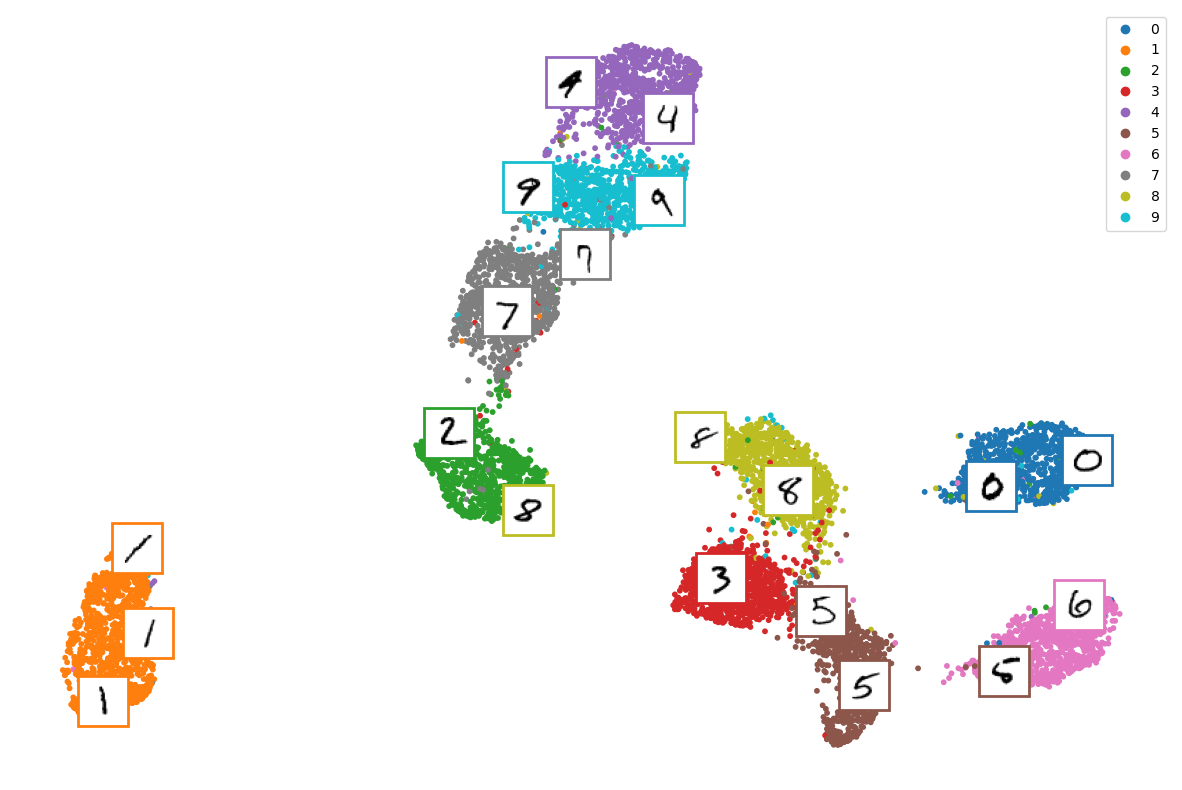

In [20]:
# Plot embedding with example images:
fig, ax = plt.subplots(figsize=(15, 10))
cmap = plt.cm.tab10
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=labels_test, s=10, cmap=cmap)
ax.legend(*scatter.legend_elements())
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embedding):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 4:            # If far enough from other images...
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(test_dataset[index][0][0], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels_test[index]), "lw": 2})
        fig.gca().add_artist(imagebox)
ax.axis("off");

In [21]:
# k-means clustering of embedding:
kmeans = KMeans(n_clusters=10, random_state=4)
kmeans.fit(embedding)
clusters = pd.DataFrame(kmeans.labels_, columns=['Cluster'])

classes = np.array(labels_test)
class_names = [0,1,2,3,4,5,6,7,8,9]

clust0 = clusters.loc[clusters['Cluster'] == 0].index.to_numpy()
clust1 = clusters.loc[clusters['Cluster'] == 1].index.to_numpy()
clust2 = clusters.loc[clusters['Cluster'] == 2].index.to_numpy()
clust3 = clusters.loc[clusters['Cluster'] == 3].index.to_numpy()
clust4 = clusters.loc[clusters['Cluster'] == 4].index.to_numpy()
clust5 = clusters.loc[clusters['Cluster'] == 5].index.to_numpy()
clust6 = clusters.loc[clusters['Cluster'] == 6].index.to_numpy()
clust7 = clusters.loc[clusters['Cluster'] == 7].index.to_numpy()
clust8 = clusters.loc[clusters['Cluster'] == 8].index.to_numpy()
clust9 = clusters.loc[clusters['Cluster'] == 9].index.to_numpy()
cluster_list = [clust0, clust1, clust2, clust3, clust4, clust5, clust6, clust7, clust8, clust9]

real_labels = np.concatenate([classes[clust0], classes[clust1], classes[clust2], classes[clust3], classes[clust4], classes[clust5],
                             classes[clust6], classes[clust7], classes[clust8], classes[clust9]])
pred_labels = []

for cluster in cluster_list:
    unique, pos = np.unique(classes[cluster], return_inverse=True)
    maxpos = np.bincount(pos).argmax()
    cluster_label = unique[maxpos]
    for i in range(len(cluster)):
        pred_labels.append(cluster_label)

pred_labels = np.array(pred_labels)

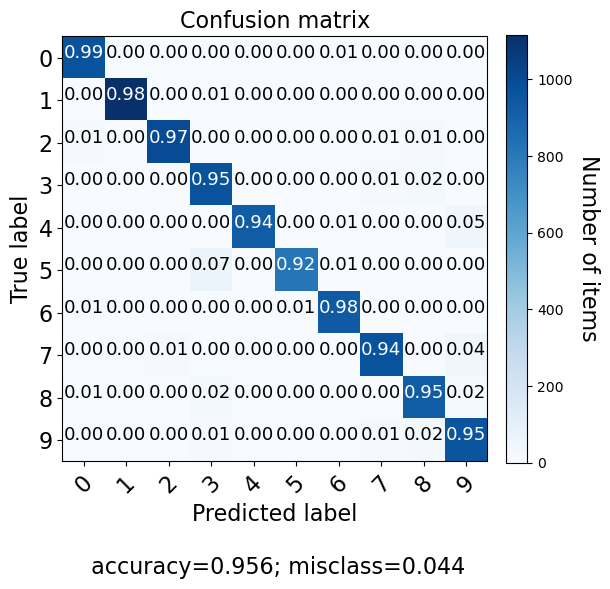

In [22]:
# Plot confusion matrix:
cm = confusion_matrix(real_labels, pred_labels, labels=class_names)
plot_confusion_matrix(cm, target_names=class_names)

### Question - are you satisfied with the confusion matrix?

Is the performance "good enough"? If not, what do you think is the problem, and how could it be solved in a simple manner? And if this is not enough, discuss what else could be done. 

### Final questions - could you learn the number of digits?

Imagine that you didn't know the digits (or something else like zebra calls!), and wanted to estimate this. Can you think of how to do that, and would you be sure to get the right result or a reasonable estimate of it?